# 13. Computer Vision
Ở chương “Mạng Nơ-ron Tích chập”, chúng tôi đã giới thiệu các mô hình học sâu thường được sử dụng trong lĩnh vực thị giác máy tính và đã cùng thực hành một số tác vụ phân loại hình ảnh đơn giản. Trong chương này, chúng tôi sẽ giới thiệu các phương pháp *tăng cường hình ảnh* (**image augmentation**), phương pháp *tinh chỉnh* (**fine-tuning**) và áp dụng chúng vào *phân loại hình ảnh*. Tiếp đến, ta sẽ khám phá các phương pháp phát hiện vật thể khác nhau, cùng tìm hiểu cách sử dụng các mạng tích chập đầy đủ để thực hiện phân vùng ngữ nghĩa trên hình ảnh. Sau đó, chúng tôi giải thích cách sử dụng kỹ thuật *truyền tải phong cách* (**style transfer**) để tạo nên những hình ảnh trông giống như bìa của cuốn sách này. Cuối cùng, chúng tôi sẽ thực hiện các bài tập thực hành trên hai bộ dữ liệu thị giác máy tính quan trọng để xem lại nội dung của chương này và những chương trước.

## 13.1. Image Augmentation
Trong Section 7.1 chúng ta có đề cập đến việc các bộ dữ liệu lớn là điều kiện tiên quyết cho sự thành công của các mạng nơ-ron sâu. Kỹ thuật tăng cường ảnh giúp mở rộng kích thước của tập dữ liệu huấn luyện thông qua việc áp dụng một loạt thay đổi ngẫu nhiên trên các mẫu ảnh, từ đó tạo ra các mẫu huấn luyện tuy tương tự nhưng vẫn có sự khác biệt. Cũng có thể giải thích tác dụng của tăng cường ảnh là việc thay đổi ngẫu nhiên các mẫu dùng cho huấn luyện, làm giảm sự phụ thuộc của mô hình vào một số thuộc tính nhất định. Do đó giúp cải thiện năng lực khái quát hóa của mô hình.

Chẳng hạn, ta có thể cắt tập ảnh theo các cách khác nhau, để các đối tượng ta quan tâm xuất hiện ở các vị trí khác nhau, vì vậy giảm sự phụ thuộc của mô hình vào vị trí xuất hiện của đối tượng. Ta cũng có thể điều chỉnh độ sáng, màu sắc, và các yếu tố khác để giảm độ nhạy màu sắc của mô hình. Có thể khẳng định rằng kỹ thuật tăng cường ảnh đóng góp rất lớn cho sự thành công của mạng AlexNet. Tới đây, chúng ta sẽ thảo luận về kỹ thuật mà được sử dụng rộng rãi trong lĩnh vực thị giác máy tính này.

Trước tiên, thực hiện nhập các gói và mô-đun cần thiết.

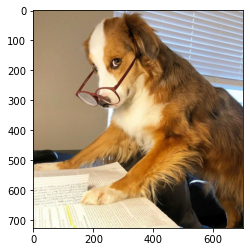

In [7]:
import torch
from torchvision import transforms, utils
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline

img = Image.open("images/dog.jpg")
plt.imshow(img)

### 13.1.1. Lật và Cắt ảnh

## 13.3. Phát hiện Vật thể và Khoanh vùng Đối tượng (Khung chứa)
Ở phần trước, chúng ta đã giới thiệu nhiều loại mô hình dùng cho phân loại ảnh. Trong tác vụ phân loại ảnh, ta giả định chỉ có duy nhất một đối tượng trong ảnh và ta chỉ tập trung xác định nó thuộc về nhóm nào. Tuy nhiên, ở nhiều tình huống cùng lúc sẽ có nhiều đối tượng trong ảnh mà ta quan tâm. Ta không chỉ muốn phân loại chúng mà còn muốn xác định vị trí cụ thể của chúng ở trong ảnh. Trong lĩnh vực thị giác máy tính, những tác vụ như thế được gọi là phát hiện vật thể (hoặc nhận dạng vật thể).

Phát hiện vật thể được sử dụng rộng rãi trong nhiều lĩnh vực. Chẳng hạn, trong công nghệ xe tự hành, ta cần lên lộ trình bằng cách xác định các vị trí của phương tiện di chuyển, người đi đường, đường xá và các vật cản trong các ảnh được thu về từ video. Robot cần thực hiện kiểu tác vụ này để phát hiện các đối tượng mà chúng quan tâm. Hay các hệ thống an ninh cần phát hiện các mục tiêu bất thường, ví dụ như các đối tượng xâm nhập bất hợp pháp hoặc bom mìn.

In [1]:
%matplotlib inline
from d2l import torch as d2l

Kế tiếp, ta nạp các ảnh mẫu sẽ sử dụng trong phần này. Ta có thể thấy trong hình là một con chó ở bên phải và một con mèo ở bên trái. Chúng là hai đối tượng chính trong ảnh này.

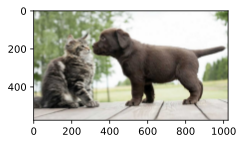

In [4]:
d2l.set_figsize()
img = d2l.plt.imread('images/cat-and-dog.jpg')
d2l.plt.imshow(img);

### 13.3.1. Khung chứa
Để phát hiện vật thể, ta thường sử dụng khung chứa để mô tả vị trí của mục tiêu. Khung chứa là một khung hình chữ nhật có thể được xác định bởi hai tọa độ: tọa độ  $x$ ,  $y$  góc trên bên trái và tọa độ  $x$ ,  $y$  góc dưới bên phải của khung hình chữ nhật. Ta có thể định nghĩa các khung chứa của con chó và con mèo trong ảnh dựa vào thông tin tọa độ của ảnh trên. Gốc tọa độ của ảnh trên là góc trên bên trái của ảnh, chiều sang phải và xuống dưới lần lượt là chiều dương của trục  $x$  và trục  $y$ .

In [12]:
# bbox is the abbreviation for bounding box
dog_bbox, cat_bbox = [290, 80, 980, 520], [0, 150, 360, 520]

Ta có thể vẽ khung chứa ngay trên ảnh để kiểm tra tính chính xác của nó. Trước khi vẽ khung, ta định nghĩa hàm hỗ trợ `bbox_to_rect`. Nó biểu diễn khung chứa theo đúng định dạng khung chứa của `matplotlib`.

In [6]:
#@save
def bbox_to_rect(bbox, color):
    """Convert bounding box to matplotlib format."""
    # Convert the bounding box (top-left x, top-left y, bottom-right x,
    # bottom-right y) format to matplotlib format: ((upper-left x,
    # upper-left y), width, height)
    return d2l.plt.Rectangle(
        xy=(bbox[0], bbox[1]), width=bbox[2]-bbox[0], height=bbox[3]-bbox[1],
        fill=False, edgecolor=color, linewidth=2)

Sau khi vẽ khung chứa lên ảnh, có thể thấy rằng phần chính của mục tiêu về cơ bản là nằm trong khung chứa.

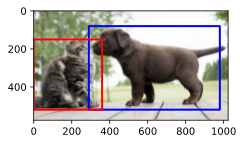

In [13]:
fig = d2l.plt.imshow(img)
fig.axes.add_patch(bbox_to_rect(dog_bbox, 'blue'))
fig.axes.add_patch(bbox_to_rect(cat_bbox, 'red'));

### 13.3.2. Tóm tắt
* Để phát hiện vật thể, ta không chỉ cần xác định tất cả đối tượng mong muốn trong ảnh mà còn cả vị trí của chúng. Các vị trí thường được biểu diễn qua các khung chứa hình chữ nhật.

### 13.3.3. Bài tập
Tìm một vài ảnh và thử dán nhãn một khung chứa bao quanh mục tiêu. So sánh sự khác nhau giữa thời gian cần để dán nhãn các khung chứa và dán nhãn các lớp hạng mục.

## 13.4. Khung neo
Các giải thuật phát hiện vật thể thường lấy mẫu ở rất nhiều vùng của ảnh đầu vào, rồi xác định xem các vùng đó có chứa đối tượng cần quan tâm hay không, và điều chỉnh biên của vùng lấy mẫu này để dự đoán khung chứa nhãn gốc của đối tượng một cách chính xác hơn. Các mô hình khác nhau có thể dùng các phương pháp lấy mẫu vùng ảnh khác nhau. Ở đây, chúng tôi sẽ giới thiệu một phương pháp đó là: tạo ra nhiều khung chứa với kích thước và tỷ lệ cạnh khác nhau với tâm trên từng điểm ảnh. Các khung chứa đó được gọi là các khung neo (**Anchor Boxes**). Chúng ta sẽ thực hành phát hiện vật thể dựa trên các khung neo ở các phần sau.

Trước tiên, hãy nhập các gói và mô-đun cần thiết cho mục này. Tại đây, ta đã chỉnh sửa độ chính xác khi in số thực của Numpy. Vì ta đang gọi hàm in của Numpy khi in các tensor, nên các tensor số thực dấu phẩy động sẽ được in ra dưới dạng súc tích hơn.